In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the required libraries

In [ ]:
import numpy as np
import cupy
import matplotlib.pyplot as plt
import os
import pickle
import math
import random
import cv2

# Function to unpickle the dataset

In [ ]:
def load_data(folder_path):

    # Initializing the variables
    train = dict()
    test = dict()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(folder_path + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(folder_path + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the proper format
    for image in train['data']:
        x_train.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    y_train = [label for label in train['labels']]
    
    for image in test['data']:
        x_test.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    y_test = [label for label in test['labels']]
    
    # Transform the data to np array format
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    return (x_train, y_train), (x_test, y_test)

# Loading the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data(os.getcwd() + '/drive/MyDrive/AIBD Assignment 2/data') #use the folder/directory path here

Handing file: test_batch
Handing file: data_batch_3
Handing file: data_batch_2
Handing file: data_batch_5
Handing file: data_batch_1
Handing file: data_batch_4


In [ ]:
# y values are integers from 0-9, each corresponding to the index of the following list
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Conversion of images to Grayscale

In [ ]:
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

In [ ]:
#checking the shape of the datasets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32)
(10000, 32, 32)
(50000,)
(10000,)


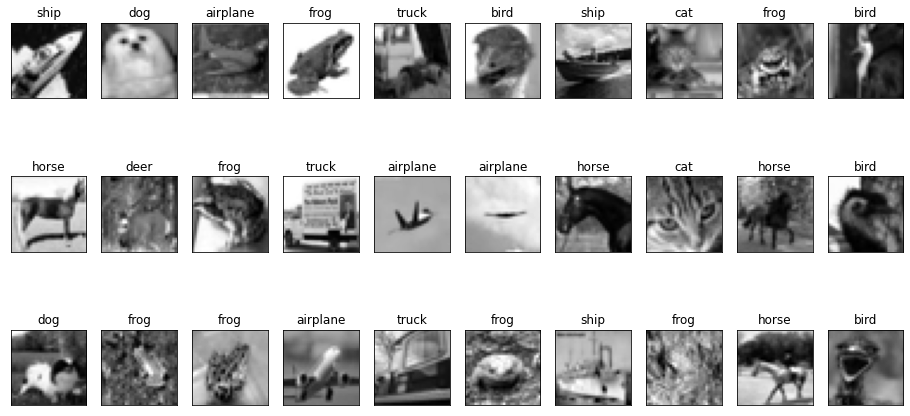

In [ ]:
#checking to see if the conversion to grayscale was successful
fig, axes = plt.subplots(ncols=10, nrows=3, figsize=(16, 8))
index = 0
for i in range(3):
    for j in range(10):
        axes[i,j].set_title(labels[y_train[index]])
        axes[i,j].imshow(x_train[index], cmap = 'gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1

# Normalization of training and testing values

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
#reshaping the values for a 2-D CNN
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
print(x_train.shape)
print(x_test.shape)

(50000, 1, 32, 32)
(10000, 1, 32, 32)


# Converting the dataset from NumPy arrays to CuPy arrays
This is done to leverage GPUs on Google Colab using CUDA. Please find more about CuPy here: https://cupy.dev/

In [ ]:
cupy.cuda.Device(0).use()
x_train = cupy.array(x_train, dtype=cupy.float32)
y_train = cupy.array(y_train, dtype=cupy.int32)
x_test = cupy.array(x_test, dtype=cupy.float32)
y_test = cupy.array(y_test, dtype=cupy.int32)
print(x_train.shape)
print(x_test.shape)

(50000, 1, 32, 32)
(10000, 1, 32, 32)


# Custom Kernels in CuPy to leverage GPUs and reduce speed over for loops
References used: Course Content of [CS6023 GPU Programming](http://www.cse.iitm.ac.in/~rupesh/teaching/gpu/jan22/) and [official documentation of CuPy ](https://docs.cupy.dev/en/stable/reference/generated/cupy.RawKernel.html#cupy.RawKernel)for custom kernels.

Note that the code written in the cells for kernels are parsed by CuPy.

## Kernel for convolution

In [ ]:
import cupy
conv = cupy.RawKernel(r'''
extern "C" __global__ void conv(float *weights, float *input, float *bias, float *output, int weight_height, int height, int channels, int out_height, int out_channels){

    int img_id = blockIdx.x, feature_id = threadIdx.z, weight_id = blockIdx.z, pixel = blockIdx.y;
    float *my_filter = &weights[weight_id * weight_height * weight_height * channels + feature_id * weight_height * weight_height];
    float *my_bias = &bias[weight_id];
    float *my_input = &input[img_id * channels * height * height + feature_id * height * height];
    float *my_output = &output[img_id * out_channels * out_height * out_height + weight_id * out_height * out_height];

    int final_pid = (pixel % out_height) * 2 + (2 * height * (pixel/out_height));

    
    atomicAdd(&my_output[pixel], my_input[final_pid + height * threadIdx.y + threadIdx.x] * my_filter[threadIdx.x + weight_height*threadIdx.y]);
    if (feature_id == 0 and threadIdx.x == 0 and threadIdx.y == 0){
      atomicAdd(&my_output[pixel], my_bias[0]);
    }

}
''', 'conv')

## Kernels for Backpropagation 

In [ ]:
#Kernel for weights
conv_w_backward = cupy.RawKernel(r'''
extern "C" __global__ void conv_weight_backprop(float *weights, float *new_weights, float *new_bias, float *input, float *bias, float *output, int weight_height, int height, int channels, int out_height, int out_channels, float learning_rate){


    int img_id = blockIdx.x, feature_id = threadIdx.z, weight_id = blockIdx.z, pixel = blockIdx.y;
    float *my_filter = &weights[weight_id * weight_height * weight_height * channels + feature_id * weight_height * weight_height];
    float *my_new_filter = &new_weights[weight_id * weight_height * weight_height * channels + feature_id * weight_height * weight_height];
    float my_bias = bias[weight_id];
    float *my_new_bias = &new_bias[weight_id];
    float *my_input = &input[img_id * channels * height * height + feature_id * height * height];
    float *my_output = &output[img_id * out_channels * out_height * out_height + weight_id * out_height * out_height];

    int final_pid = (pixel % out_height) * 2 + (2 * height * (pixel/out_height));

    atomicAdd(&my_new_filter[threadIdx.x + weight_height*threadIdx.y], my_filter[threadIdx.x + weight_height*threadIdx.y]/(gridDim.x * gridDim.y) - (learning_rate * my_input[final_pid + height * threadIdx.y + threadIdx.x] * my_output[pixel]));

    if (threadIdx.x == 0 and threadIdx.y == 0 and feature_id == 0) {
      
      atomicAdd(&my_new_bias[0], my_bias/(gridDim.x * gridDim.y) - (learning_rate * my_output[pixel]));
    
      }
    
}
''', 'conv_weight_backprop')

#Kernel for gradients of previous layer 
conv_l_backward = cupy.RawKernel(r'''
extern "C" __global__ void conv_layer_backprop(float *weights, float *new_weights, float *new_bias,float *input, float *bias, float *output, int weight_height, int height, int channels, int out_height, int out_channels, float learning_rate){


    int img_id = blockIdx.x, feature_id = threadIdx.z, weight_id = blockIdx.z, pixel = blockIdx.y;
    float *my_filter = &weights[weight_id * weight_height * weight_height * channels + feature_id * weight_height * weight_height];
    float *my_input = &input[img_id * channels * height * height + feature_id * height * height];
    float *my_output = &output[img_id * out_channels * out_height * out_height + weight_id * out_height * out_height];

    int final_pid = (pixel % out_height) * 2 + (2 * height * (pixel/out_height));

    atomicAdd(&my_input[final_pid + height * threadIdx.y + threadIdx.x], my_output[pixel] * my_filter[threadIdx.x + weight_height*threadIdx.y]);

}


''', 'conv_layer_backprop')

## Kernels for MaxPool

In [ ]:
# Maxpool foward pass
maxpool = cupy.RawKernel(r'''
__device__ __forceinline__ float atomicMaxFloat (float * addr, float value) {
    float old;
    old = (value >= 0) ? __int_as_float(atomicMax((int *)addr, __float_as_int(value))) :
         __uint_as_float(atomicMin((unsigned int *)addr, __float_as_uint(value)));

    return old;
}

extern "C" __global__ void maxpool(float *input, float *output, int window, int stride, int height, int channels, int out_height){

    int img_id = blockIdx.x, feature_id = blockIdx.z, pixel = blockIdx.y;

    float *my_input = &input[img_id * channels * height * height + feature_id * height * height];

    float *my_output = &output[img_id * channels * out_height * out_height + feature_id * out_height * out_height];

    int final_pid = (pixel % out_height) * stride + (stride * height * (pixel/out_height));

    __shared__ float w_max;

    if (threadIdx.x == 0 and threadIdx.y == 0) w_max = my_input[final_pid + height*threadIdx.y + threadIdx.x];

    __syncthreads();

    atomicMaxFloat(&w_max, my_input[final_pid + height*threadIdx.y + threadIdx.x]);


    __syncthreads();

    if (threadIdx.x == 0 and threadIdx.y == 0) {
      my_output[pixel] = w_max;

    }

}


''', 'maxpool')

#MaxPool backpropagation
maxpool_backward = cupy.RawKernel(r'''

__device__ __forceinline__ float atomicMaxFloat (float * addr, float value) {
    float old;
    old = (value >= 0) ? __int_as_float(atomicMax((int *)addr, __float_as_int(value))) :
         __uint_as_float(atomicMin((unsigned int *)addr, __float_as_uint(value)));

    return old;
}

extern "C" __global__ void maxpool_backprop(float *input, float *output, int window, int stride, int height, int channels, int out_height){

    int img_id = blockIdx.x, feature_id = blockIdx.z, pixel = blockIdx.y;

    float *my_input = &input[img_id * channels * height * height + feature_id * height * height];

    float *my_output = &output[img_id * channels * out_height * out_height + feature_id * out_height * out_height];

    int final_pid = (pixel % out_height) * stride + (stride * height * (pixel/out_height));

    __shared__ float w_max;

    if (threadIdx.x == 0 and threadIdx.y == 0) w_max = my_input[final_pid + height*threadIdx.y + threadIdx.x];

    __syncthreads();

    atomicMaxFloat(&w_max, my_input[final_pid + height*threadIdx.y + threadIdx.x]);
    __syncthreads();

    if (w_max == my_input[final_pid + height*threadIdx.y + threadIdx.x]) {
      
      my_input[final_pid + height*threadIdx.y + threadIdx.x] = my_output[pixel];    
      }

    else my_input[final_pid + height*threadIdx.y + threadIdx.x] = 0;


}


''', 'maxpool_backprop')

# CNN Class

In [ ]:
class CNN:
    
    #initialization of parameters
    def __init__(self, kernel_size, stride, in_channels, out_channels):
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = cupy.random.uniform(-1, 1, (self.out_channels* self.in_channels* self.kernel_size* self.kernel_size), dtype=cupy.float32)

        self.bias = cupy.random.uniform(-1, 1, (self.out_channels, ), dtype=cupy.float32)

    def forward(self, input_vector):
        batch_size, channels, height, height = input_vector.shape

        wh = self.kernel_size

        out_height = height//2

        input_vector = input_vector.reshape(-1, )

        output = cupy.zeros(batch_size*self.out_channels*out_height*out_height, dtype=cupy.float32)#.reshape(batch_size, self.out_channels, out_height, out_height)
        weight1 = self.weight
        bias1 = self.bias

        out_channels = self.out_channels

        conv( (batch_size, out_height * out_height, out_channels), 
              (wh, wh, channels), 
              (weight1, input_vector, bias1, output, wh, height, channels, out_height, out_channels)) 
        

        return output.reshape(batch_size, out_channels, out_height, out_height)

    def backward(self, input_vector, output_vector, learning_rate):

        batch_size, channels, height, height = input_vector.shape
        _, out_channels, out_height, out_height = output_vector.shape

        wh = self.kernel_size

        input_vector = input_vector.reshape(-1, )
        output_vector = output_vector.reshape(-1, )

        new_weights = cupy.zeros(wh*wh*channels*out_channels, dtype=cupy.float32)
        new_bias = cupy.zeros(out_channels, dtype=cupy.float32) 
        backprop = cupy.zeros(height*height*batch_size*channels, dtype=cupy.float32)


        conv_w_backward((batch_size, out_height * out_height, out_channels), 
                        (wh, wh, channels), 
                        (self.weight, new_weights, new_bias, input_vector, self.bias, output_vector, self.kernel_size, height, channels, out_height, out_channels, learning_rate))
            


        conv_l_backward((batch_size, out_height * out_height, out_channels), (wh, wh, channels), (self.weight, new_weights, new_bias, backprop, self.bias, output_vector, wh, height, channels, out_height, out_channels, learning_rate))

  
        self.weight = new_weights
        self.bias = new_bias
        return backprop.reshape(batch_size, channels, height, height)

# ReLU Activation Class

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, input_vector):

        return (input_vector > 0 ) * input_vector

    def backward(self, input_vector, output_vector):

        return (input_vector > 0) * output_vector

# MaxPool Class

In [ ]:
class MaxPool:

    def __init__(self, stride, dimension):
        index = None
        self.dim = dimension
        self.stride = stride

    def forward(self, input_vector):
        batch_size, channels, height, width = input_vector.shape

        out_height = height//2

        output = cupy.zeros(batch_size*channels*out_height*out_height, dtype = cupy.float32).reshape(batch_size, channels, out_height, out_height)

        maxpool(  (batch_size, out_height*out_height, channels), 
                  (self.dim, self.dim, 1),
                  (input_vector, output, self.dim, self.stride, height, channels, out_height))

        return output

    def backward(self, input_vector, output_vector):

        batch_size, channels, height, height = input_vector.shape
        _, _, out_height, out_height = output_vector.shape
      

        maxpool_backward((batch_size, out_height*out_height, channels), 
                          (self.dim, self.dim, 1),
                         (input_vector, output_vector, self.dim, self.stride, height, channels, out_height))
        
        return input_vector

# Categorical Cross Entropy Loss Class

In [ ]:
class Cross_Entropy_Loss:
    
    def __init__(self):
        pass

    def calculate(self, input_vector, y_actual):

        batch_size, channels, _, _ = input_vector.shape
        prediction = input_vector.reshape(batch_size, channels)

        softmax_probabilities = cupy.exp(prediction)/cupy.exp(prediction).sum(-1, keepdims=True)

        accuracy = cupy.equal(cupy.argmax(softmax_probabilities, -1), y_actual).mean()
        loss = -cupy.log(softmax_probabilities[cupy.arange(batch_size), y_actual]).mean()

        backprop = (1/batch_size) * (softmax_probabilities)

        backprop[cupy.arange(batch_size, dtype=cupy.int32), y_actual] = (1/batch_size) * (softmax_probabilities[cupy.arange(batch_size, dtype=cupy.int32), y_actual] - 1)

        return loss, backprop.reshape(input_vector.shape), accuracy

# Class to define the network

In [ ]:
class Model:

    def __init__(self,):

        self.conv1 = CNN(kernel_size=2, stride=2, in_channels=1, out_channels=64)
        self.conv2 = CNN(kernel_size=2, stride=2, in_channels=64, out_channels=10)
        self.conv3 = CNN(kernel_size=2, stride=2, in_channels=10, out_channels=10)
        self.pool1 = MaxPool(stride=2, dimension=2)
        self.pool2 = MaxPool(stride=2, dimension=2)
        self.pool3 = MaxPool(stride=2, dimension=2)
        self.activation = ReLU()

        self.criterion = Cross_Entropy_Loss()

    def forward(self, input_vector, y_actual, learning_rate):

        out1 = self.conv1.forward(input_vector)
        out2 = self.activation.forward(out1)
        out3 = self.pool1.forward(out2)
        out4 = self.conv2.forward(out3)
        out5 = self.activation.forward(out4)
        out6 = self.pool2.forward(out5)
        output = self.conv3.forward(out6)

        loss, backprop, accuracy = self.criterion.calculate(output, y_actual)

        backprop = self.conv3.backward(out6, backprop, learning_rate)
        backprop = self.pool2.backward(out5, backprop)
        backprop = self.activation.backward(out4, backprop)
        backprop = self.conv2.backward(out3, backprop, learning_rate)
        backprop = self.pool1.backward(out2, backprop)
        backprop = self.activation.backward(out1, backprop)
        self.conv1.backward(input_vector, backprop, learning_rate)

        return loss
    
    def evaluate(self, input_vector, y_actual):
        out1 = self.conv1.forward(input_vector)
        out2 = self.activation.forward(out1)
        out3 = self.pool1.forward(out2)
        out4 = self.conv2.forward(out3)
        out5 = self.activation.forward(out4)
        out6 = self.pool2.forward(out5)
        output = self.conv3.forward(out6)
        loss, backprop, accuracy = self.criterion.calculate(output, y_actual)
        return loss, accuracy

# Selecting the number of images per batch and iterations (epochs) and network setup

In [ ]:
images_per_batch = 64
epochs = 50
NeuralNetwork = Model()

# Training the Model

In [ ]:
from tqdm import tqdm
loss_storage = []
test_loss_storage = []
training_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    loss_epoch = 0
    test_loss_epoch = 0
    accuracy_epoch = 0
    test_accuracy_epoch = 0
    print('Training')
    for idx in tqdm(range(0, len(x_train), images_per_batch)):

        input_batch = x_train[idx:idx+images_per_batch]
        y_actual = y_train[idx:idx+images_per_batch]
        loss = NeuralNetwork.forward(input_batch, y_actual, cupy.float32(1e-3))
        _, accuracy = NeuralNetwork.evaluate(input_batch, y_actual)
        
        loss_epoch += loss
        accuracy_epoch += accuracy

    print('Testing')

    for idx in tqdm(range(0, len(x_test), images_per_batch)):

        input_batch = x_test[idx:idx+images_per_batch]
        y_actual = y_test[idx:idx+images_per_batch]
        loss, accuracy = NeuralNetwork.evaluate(input_batch, y_actual)
        
        test_loss_epoch += loss
        test_accuracy_epoch += accuracy


    print("Training Loss :", loss_epoch/(len(x_train)//images_per_batch), "Test Loss :", test_loss_epoch/(len(x_test)//images_per_batch))
    print("Training Accuracy :", accuracy_epoch/(len(x_train)//images_per_batch), "Test Accuracy :", test_accuracy_epoch/(len(x_test)//images_per_batch))

    loss_storage.append(loss_epoch/(len(x_train)//images_per_batch))
    test_loss_storage.append(test_loss_epoch/(len(x_test)//images_per_batch))
    training_accuracy.append(accuracy_epoch/(len(x_train)//images_per_batch))
    test_accuracy.append(test_accuracy_epoch/(len(x_test)//images_per_batch))
    
    print('---------------------------------\nFinished epoch %d\n---------------------------------' % (epoch+1))

Training


100%|██████████| 782/782 [00:27<00:00, 28.75it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.64it/s] 


Training Loss : 3.3945696 Test Loss : 2.7498777
Training Accuracy : 0.1074343790012804 Test Accuracy : 0.1070713141025641
---------------------------------
Finished epoch 1
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.02it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.44it/s] 


Training Loss : 2.6395943 Test Loss : 2.598374
Training Accuracy : 0.11669734314980794 Test Accuracy : 0.11388221153846154
---------------------------------
Finished epoch 2
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.04it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


Training Loss : 2.5371048 Test Loss : 2.5253174
Training Accuracy : 0.12231914212548016 Test Accuracy : 0.1194911858974359
---------------------------------
Finished epoch 3
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.21it/s] 


Training Loss : 2.4805508 Test Loss : 2.480816
Training Accuracy : 0.1259403008962868 Test Accuracy : 0.12209535256410256
---------------------------------
Finished epoch 4
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.93it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 98.66it/s] 


Training Loss : 2.442582 Test Loss : 2.4491603
Training Accuracy : 0.13064180537772088 Test Accuracy : 0.1255008012820513
---------------------------------
Finished epoch 5
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.55it/s] 


Training Loss : 2.4142823 Test Loss : 2.4243333
Training Accuracy : 0.13348271446862997 Test Accuracy : 0.1266025641025641
---------------------------------
Finished epoch 6
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.03it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.96it/s] 


Training Loss : 2.3915832 Test Loss : 2.4047759
Training Accuracy : 0.13698383482714468 Test Accuracy : 0.12880608974358973
---------------------------------
Finished epoch 7
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.05it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.21it/s] 


Training Loss : 2.3728733 Test Loss : 2.3889482
Training Accuracy : 0.13926456466069143 Test Accuracy : 0.1330128205128205
---------------------------------
Finished epoch 8
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.05it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.46it/s] 


Training Loss : 2.3571987 Test Loss : 2.3747487
Training Accuracy : 0.14208546734955185 Test Accuracy : 0.13631810897435898
---------------------------------
Finished epoch 9
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.31it/s] 


Training Loss : 2.3435428 Test Loss : 2.3624315
Training Accuracy : 0.14488636363636365 Test Accuracy : 0.13842147435897437
---------------------------------
Finished epoch 10
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.06it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.18it/s] 


Training Loss : 2.3318307 Test Loss : 2.3528101
Training Accuracy : 0.1471070742637644 Test Accuracy : 0.13862179487179488
---------------------------------
Finished epoch 11
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.22it/s] 


Training Loss : 2.3217463 Test Loss : 2.3445065
Training Accuracy : 0.149627880921895 Test Accuracy : 0.14002403846153846
---------------------------------
Finished epoch 12
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.28it/s] 


Training Loss : 2.31297 Test Loss : 2.336749
Training Accuracy : 0.1511683738796415 Test Accuracy : 0.14212740384615385
---------------------------------
Finished epoch 13
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.17it/s] 


Training Loss : 2.3052995 Test Loss : 2.3300352
Training Accuracy : 0.15292893725992318 Test Accuracy : 0.1422275641025641
---------------------------------
Finished epoch 14
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.17it/s] 


Training Loss : 2.298251 Test Loss : 2.323743
Training Accuracy : 0.15468950064020487 Test Accuracy : 0.14212740384615385
---------------------------------
Finished epoch 15
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.27it/s] 


Training Loss : 2.2916803 Test Loss : 2.318064
Training Accuracy : 0.15540973111395648 Test Accuracy : 0.14182692307692307
---------------------------------
Finished epoch 16
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.57it/s] 


Training Loss : 2.28594 Test Loss : 2.3136766
Training Accuracy : 0.15618998079385404 Test Accuracy : 0.1429286858974359
---------------------------------
Finished epoch 17
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.03it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.50it/s] 


Training Loss : 2.2808483 Test Loss : 2.308915
Training Accuracy : 0.15779049295774647 Test Accuracy : 0.14362980769230768
---------------------------------
Finished epoch 18
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.12it/s] 


Training Loss : 2.2758667 Test Loss : 2.3047419
Training Accuracy : 0.15945102432778488 Test Accuracy : 0.14192708333333334
---------------------------------
Finished epoch 19
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.15it/s] 


Training Loss : 2.2712367 Test Loss : 2.3012707
Training Accuracy : 0.16053137003841228 Test Accuracy : 0.1438301282051282
---------------------------------
Finished epoch 20
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.07it/s] 


Training Loss : 2.2669604 Test Loss : 2.2974973
Training Accuracy : 0.16153169014084506 Test Accuracy : 0.14413060897435898
---------------------------------
Finished epoch 21
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.12it/s] 


Training Loss : 2.2627952 Test Loss : 2.294141
Training Accuracy : 0.1634122919334187 Test Accuracy : 0.14493189102564102
---------------------------------
Finished epoch 22
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.03it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.84it/s] 


Training Loss : 2.2588937 Test Loss : 2.2913475
Training Accuracy : 0.164672695262484 Test Accuracy : 0.1461338141025641
---------------------------------
Finished epoch 23
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.02it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.43it/s] 


Training Loss : 2.2551093 Test Loss : 2.2882
Training Accuracy : 0.1657530409731114 Test Accuracy : 0.14833733974358973
---------------------------------
Finished epoch 24
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.26it/s] 


Training Loss : 2.2514262 Test Loss : 2.2851548
Training Accuracy : 0.16735355313700384 Test Accuracy : 0.1502403846153846
---------------------------------
Finished epoch 25
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.27it/s] 


Training Loss : 2.2478595 Test Loss : 2.28239
Training Accuracy : 0.16829385403329064 Test Accuracy : 0.15234375
---------------------------------
Finished epoch 26
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.02it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.35it/s] 


Training Loss : 2.2443242 Test Loss : 2.2790413
Training Accuracy : 0.16987435979513443 Test Accuracy : 0.15354567307692307
---------------------------------
Finished epoch 27
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.25it/s] 


Training Loss : 2.240832 Test Loss : 2.2760139
Training Accuracy : 0.17089468629961588 Test Accuracy : 0.15625
---------------------------------
Finished epoch 28
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.10it/s] 


Training Loss : 2.2373588 Test Loss : 2.2735417
Training Accuracy : 0.17249519846350833 Test Accuracy : 0.15655048076923078
---------------------------------
Finished epoch 29
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.01it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.14it/s] 


Training Loss : 2.2339458 Test Loss : 2.270628
Training Accuracy : 0.1743958066581306 Test Accuracy : 0.15845352564102563
---------------------------------
Finished epoch 30
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.24it/s] 


Training Loss : 2.2306156 Test Loss : 2.2677453
Training Accuracy : 0.17503601152368758 Test Accuracy : 0.15935496794871795
---------------------------------
Finished epoch 31
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.10it/s] 


Training Loss : 2.2272935 Test Loss : 2.2648377
Training Accuracy : 0.1771366837387964 Test Accuracy : 0.1603565705128205
---------------------------------
Finished epoch 32
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.02it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.50it/s] 


Training Loss : 2.2238903 Test Loss : 2.2621226
Training Accuracy : 0.17881722151088347 Test Accuracy : 0.1624599358974359
---------------------------------
Finished epoch 33
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.95it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.55it/s] 


Training Loss : 2.2204883 Test Loss : 2.2592096
Training Accuracy : 0.18067781690140844 Test Accuracy : 0.1647636217948718
---------------------------------
Finished epoch 34
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.10it/s] 


Training Loss : 2.2170515 Test Loss : 2.2561016
Training Accuracy : 0.18231834186939821 Test Accuracy : 0.1672676282051282
---------------------------------
Finished epoch 35
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.32it/s] 


Training Loss : 2.2135866 Test Loss : 2.253755
Training Accuracy : 0.18487916133162613 Test Accuracy : 0.17057291666666666
---------------------------------
Finished epoch 36
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.94it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.17it/s] 


Training Loss : 2.2101848 Test Loss : 2.2505543
Training Accuracy : 0.18707986555697823 Test Accuracy : 0.17127403846153846
---------------------------------
Finished epoch 37
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 98.87it/s] 


Training Loss : 2.206608 Test Loss : 2.2472556
Training Accuracy : 0.1889004481434059 Test Accuracy : 0.17267628205128205
---------------------------------
Finished epoch 38
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.95it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.14it/s] 


Training Loss : 2.2030728 Test Loss : 2.2444215
Training Accuracy : 0.1903809218950064 Test Accuracy : 0.17457932692307693
---------------------------------
Finished epoch 39
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.95it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.63it/s] 


Training Loss : 2.199595 Test Loss : 2.2411249
Training Accuracy : 0.19212147887323944 Test Accuracy : 0.1750801282051282
---------------------------------
Finished epoch 40
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.96it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 98.88it/s] 


Training Loss : 2.1961331 Test Loss : 2.2377837
Training Accuracy : 0.19364196542893725 Test Accuracy : 0.17708333333333334
---------------------------------
Finished epoch 41
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.45it/s] 


Training Loss : 2.1926236 Test Loss : 2.2344599
Training Accuracy : 0.19554257362355953 Test Accuracy : 0.17868589743589744
---------------------------------
Finished epoch 42
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.99it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.30it/s] 


Training Loss : 2.1892369 Test Loss : 2.2309954
Training Accuracy : 0.19730313700384122 Test Accuracy : 0.18028846153846154
---------------------------------
Finished epoch 43
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.89it/s] 


Training Loss : 2.185834 Test Loss : 2.2281303
Training Accuracy : 0.19824343790012805 Test Accuracy : 0.18189102564102563
---------------------------------
Finished epoch 44
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.97it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.20it/s] 


Training Loss : 2.1823251 Test Loss : 2.225111
Training Accuracy : 0.19998399487836108 Test Accuracy : 0.18319310897435898
---------------------------------
Finished epoch 45
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.96it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


Training Loss : 2.1788554 Test Loss : 2.2217078
Training Accuracy : 0.20112435979513443 Test Accuracy : 0.18629807692307693
---------------------------------
Finished epoch 46
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.55it/s] 


Training Loss : 2.1752899 Test Loss : 2.2186034
Training Accuracy : 0.20306498079385404 Test Accuracy : 0.18840144230769232
---------------------------------
Finished epoch 47
---------------------------------
Training


100%|██████████| 782/782 [00:27<00:00, 28.96it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 98.86it/s] 


Training Loss : 2.171756 Test Loss : 2.2158601
Training Accuracy : 0.2044654289372599 Test Accuracy : 0.18950320512820512
---------------------------------
Finished epoch 48
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 28.98it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.12it/s] 


Training Loss : 2.1681526 Test Loss : 2.2126884
Training Accuracy : 0.20584587067861715 Test Accuracy : 0.1912059294871795
---------------------------------
Finished epoch 49
---------------------------------
Training


100%|██████████| 782/782 [00:26<00:00, 29.00it/s]


Testing


100%|██████████| 157/157 [00:01<00:00, 99.64it/s] 


Training Loss : 2.1645455 Test Loss : 2.2091312
Training Accuracy : 0.20748639564660692 Test Accuracy : 0.19381009615384615
---------------------------------
Finished epoch 50
---------------------------------


# Visualizing the loss

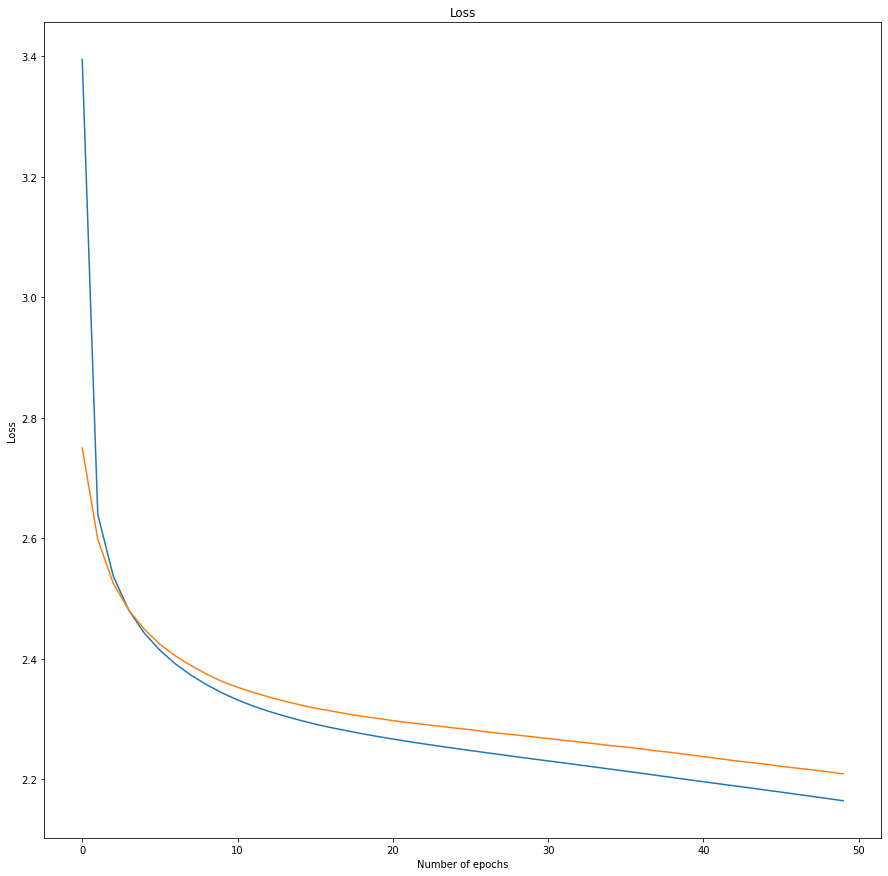

In [ ]:
loss_storage = np.array([float(i) for i in loss_storage])
test_loss_storage = np.array([float(i) for i in test_loss_storage])
plt.figure(figsize= (15,15))
plt.plot(np.arange(len(loss_storage)), loss_storage, label = 'Training')
plt.plot(np.arange(len(test_loss_storage)), test_loss_storage, label = 'Test')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.show()

# Visualizing the Accuracy

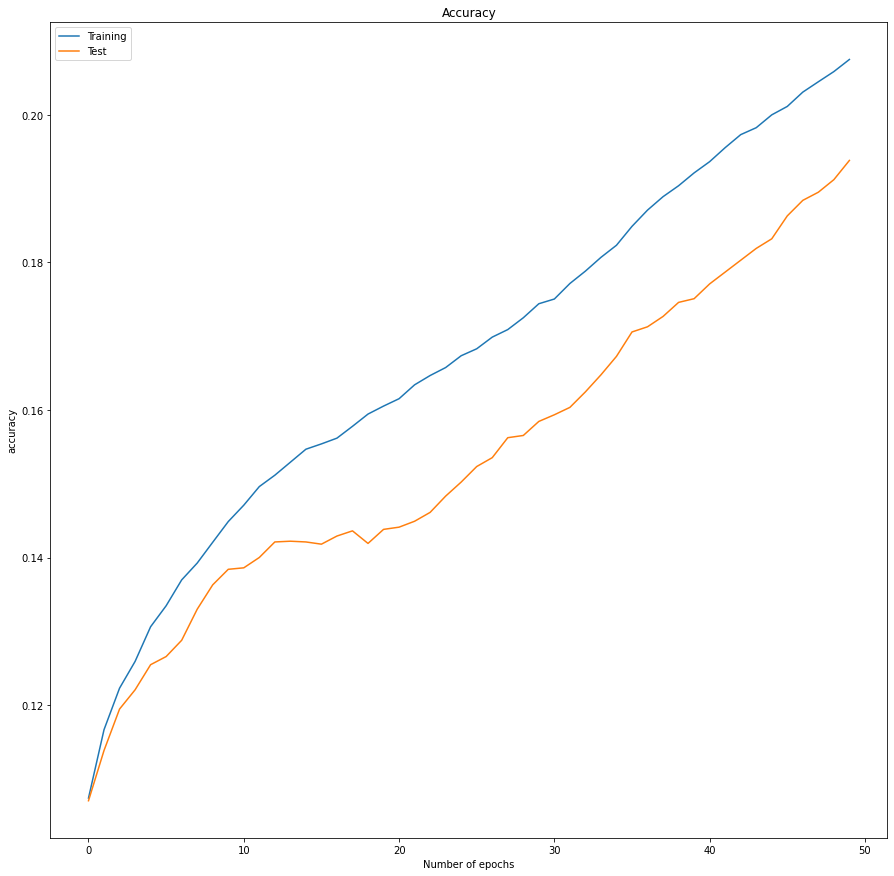

In [ ]:
accuracy_storage = np.array([float(i) for i in training_accuracy])
test_accuracy_storage = np.array([float(i) for i in test_accuracy])
plt.figure(figsize= (15,15))
plt.plot(np.arange(len(accuracy_storage)), accuracy_storage, label = 'Training')
plt.plot(np.arange(len(test_accuracy_storage)), test_accuracy_storage, label = 'Test')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Model: loss and accuracy

In [ ]:
#calculation of test loss and accuracy
idx_list = np.random.choice(10000, (10,), replace=False)
x_test_vals = x_test[idx_list]
y_test_vals = y_test[idx_list]
loss, accuracy = NeuralNetwork.evaluate(x_test_vals, y_test_vals)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

Loss:  2.0081336
Accuracy:  0.2
